# BigBrain Image Segmentation Tutorial

This tutorial will guide you through automatic segmentation techniques on the BigBrain histological dataset. We'll use several basic methods to segment gray matter from histological images, including Otsu thresholding, KMeans clustering, and other unsupervised clustering techniques.

In [21]:
# Import all required libraries
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from skimage.filters import threshold_otsu
from skimage import exposure
import requests
from tqdm import tqdm


In [22]:
# Function to download files with a progress bar
def download_file(url, dest_path):
    """Download a file from a URL to a destination path with a progress bar."""
    if not os.path.exists(dest_path):
        response = requests.get(url, stream=True)
        total = int(response.headers.get('content-length', 0))
        with open(dest_path, 'wb') as file, tqdm(
            desc=f"Downloading {os.path.basename(dest_path)}",
            total=total, unit='iB', unit_scale=True
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = file.write(data)
                bar.update(size)
    else:
        print(f"{os.path.basename(dest_path)} already exists.")


In [23]:
# Create a directory for storing data
data_dir = "bigbrain_data"
os.makedirs(data_dir, exist_ok=True)

# URLs of the BigBrain volume and segmentation
volume_url = "https://ftp.bigbrainproject.org/bigbrain-ftp/BigBrainRelease.2015/3D_Volumes/MNI-ICBM152_Space/nii/full8_400um_2009b_sym.nii.gz"
seg_url = "https://ftp.bigbrainproject.org/bigbrain-ftp/BigBrainRelease.2015/3D_Classified_Volumes/MNI-ICBM152_Space/nii/full_cls_400um_2009b_sym.nii.gz"

# Paths to save the files locally
volume_path = os.path.join(data_dir, "full8_400um_2009b_sym.nii.gz")
seg_path = os.path.join(data_dir, "full_cls_400um_2009b_sym.nii.gz")

# Download the files
download_file(volume_url, volume_path)
download_file(seg_url, seg_path)


full8_400um_2009b_sym.nii.gz already exists.
full_cls_400um_2009b_sym.nii.gz already exists.


In [24]:
# Load the NIfTI images using nibabel
img = nib.load(volume_path)
seg = nib.load(seg_path)

# Extract the image data as numpy arrays
img_data = img.get_fdata()
seg_data = seg.get_fdata()

img_data = img_data.max() - img_data

print(img_data)

# Print shape to understand dimensions (should be 3D)
print("Histology Image shape:", img_data.shape)
print("Segmentation shape:", seg_data.shape)


[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
Histology 

Slice Index 236


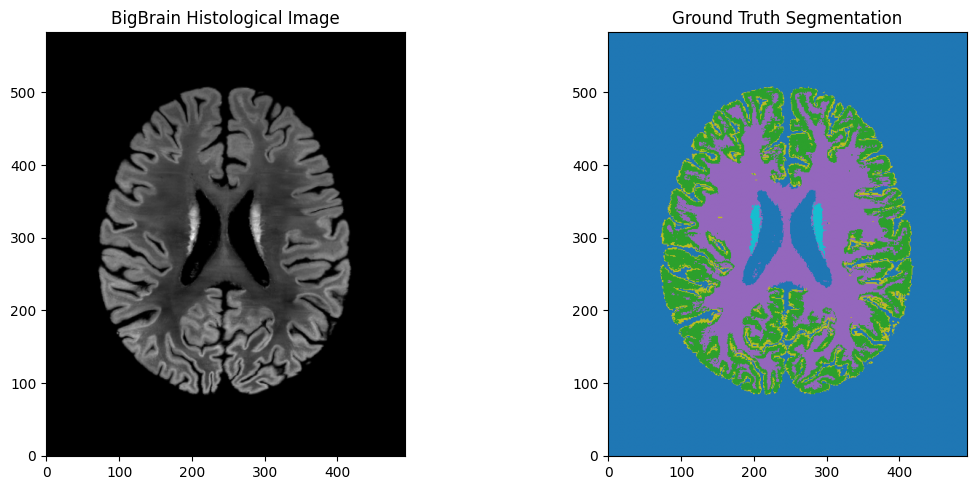

In [25]:
# Choose a representative axial slice to visualize
slice_idx = img_data.shape[2] // 2  # Middle slice
print('Slice Index', slice_idx)
# Display histological slice and associated segmentation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("BigBrain Histological Image")
plt.imshow(img_data[:, :, slice_idx].T, cmap='gray', origin='lower')

plt.subplot(1, 2, 2)
plt.title("Ground Truth Segmentation")
plt.imshow(seg_data[:, :, slice_idx].T, cmap='tab10', origin='lower')

plt.tight_layout()
plt.show()


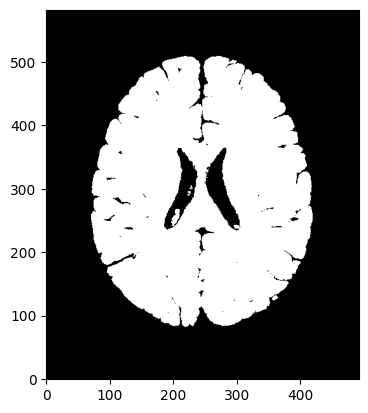

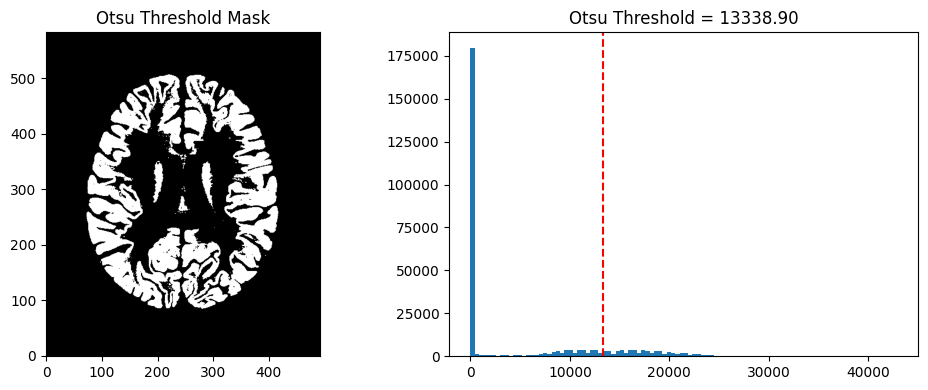

In [26]:
# Normalize the slice intensity to the range [0, 1]
slice_img = img_data[:, :, slice_idx]
slice_img_norm = slice_img
#slice_img_norm = exposure.rescale_intensity(slice_img, out_range=(0, 1))

# Apply Otsu thresholding to find an intensity threshold

pixels_greater_than_zero = slice_img_norm > 0

plt.imshow(pixels_greater_than_zero.T, cmap='gray', origin='lower')
plt.show()

otsu_thresh = threshold_otsu(slice_img_norm[ pixels_greater_than_zero])

# Create a binary mask using the threshold
otsu_mask = slice_img_norm > otsu_thresh

# Show the result
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Otsu Threshold Mask")
plt.imshow(otsu_mask.T, cmap='gray', origin='lower')

plt.subplot(1, 2, 2)
plt.hist(slice_img_norm.ravel(), bins=100)
plt.axvline(otsu_thresh, color='r', linestyle='--')
plt.title(f"Otsu Threshold = {otsu_thresh:.2f}")
plt.tight_layout()
plt.show()


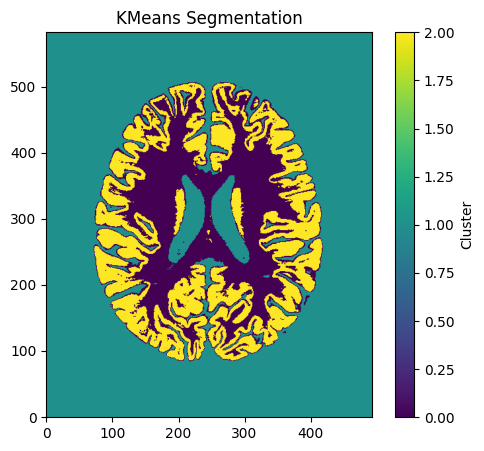

In [27]:
# Reshape the image into a 2D array of pixel intensities
flat_img = slice_img_norm.ravel().reshape(-1, 1)

# Apply KMeans clustering to group pixels into 3 clusters
kmeans_obj = KMeans(n_clusters=3, random_state=42)
kmeans = kmeans_obj.fit(flat_img)

# Reshape labels back into image shape
kmeans_mask = kmeans.labels_.reshape(slice_img.shape)

# Show the segmentation result
plt.figure(figsize=(6, 5))
plt.title("KMeans Segmentation")
plt.imshow(kmeans_mask.T, cmap='viridis', origin='lower')
plt.colorbar(label='Cluster')
plt.show()


In [28]:
# Use Agglomerative Clustering as another unsupervised method
#agglo = AgglomerativeClustering(n_clusters=3).fit(flat_img)
#agglo_mask = agglo.labels_.reshape(slice_img.shape)

#plt.figure(figsize=(6, 5))
#plt.title("Agglomerative Clustering Segmentation")
#plt.imshow(agglo_mask.T, cmap='plasma', origin='lower')
#plt.colorbar(label='Cluster')
#plt.show()


In [29]:
# Apply DBSCAN clustering
# Note: DBSCAN is sensitive to scale and density; it may return -1 for noise points
#db = DBSCAN(eps=0.03, min_samples=5).fit(flat_img)
#db_mask = db.labels_.reshape(slice_img.shape)

#plt.figure(figsize=(6, 5))
#plt.title("DBSCAN Clustering Segmentation")
#plt.imshow(db_mask.T, cmap='Accent', origin='lower')
#plt.colorbar(label='Cluster')
#plt.show()
